In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plot
from datetime import datetime, date
f = open("transaction-data-adhoc-analysis.json", "r")
td = json.load(f)
df_td = pd.DataFrame(td)

In [2]:
# create the initial order table by using string manipulation to store order quantities per item

def count(orders, col):
    order = [z for y in [x.split(",") for x in orders.split(";")] for z in y]
    order_num = int(order[order.index(col)+1][2:len(order[order.index(col)+1])-1])
    return order_num

ol = []
for x in df_td['transaction_items']:
    for y in x.split(";"):
        category, order_name, order_num = y.split(",")
        if order_name not in ol:
            ol.append(order_name)
    
for x in ol:
    df_td[x] = df_td['transaction_items'].apply(lambda row: count(row, x) if x in row else 0)

# showcase the first 5 orders in the created order table with all the included details
# can easily change the number of orders shown by changing the number enclosed in the paranthesis after "head"
df_td.head(5)

,address,birthdate,mail,name,sex,username,transaction_items,transaction_value,transaction_date,Beef Chicharon,Nutrional Milk,Orange Beans,Gummy Vitamins,Yummy Vegetables,Gummy Worms,Kimchi and Seaweed
0,USNS Wagner\nFPO AE 00917,1926/03/11,watsonbrenda@gmail.com,Jennifer Campbell,F,veronicawells,"Exotic Extras,Beef Chicharon,(x4)",5196,2022/01/12,4,0,0,0,0,0,0
1,USCGC Benson\nFPO AP 48794,2016/07/08,moorelisa@gmail.com,Melissa Kim,F,cgilbert,"Exotic Extras,Beef Chicharon,(x3);HealthyKid 3...",12056,2022/01/12,3,4,1,0,0,0,0
2,USCGC Benson\nFPO AP 48794,2016/07/08,moorelisa@gmail.com,Melissa Kim,F,cgilbert,"HealthyKid 3+,Gummy Vitamins,(x3);HealthyKid 3...",5500,2022/01/08,0,0,0,3,2,0,0
3,USCGC Benson\nFPO AP 48794,2016/07/08,moorelisa@gmail.com,Melissa Kim,F,cgilbert,"HealthyKid 3+,Yummy Vegetables,(x1)",500,2022/01/10,0,0,0,0,1,0,0
4,"33911 Hansen Loaf\nWest Sandra, ND 54188",1949/09/27,michael78@yahoo.com,Kristen Cooper,F,qhernandez,"Candy City,Orange Beans,(x3);Candy City,Gummy ...",2697,2022/01/24,0,0,3,1,0,4,0


In [3]:
# extract other relevant information from the raw transaction file by defining different functions

# function that will extract the month from each transaction date
def month(date):
    months = ['', 'January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
    return months[int(date[5:7])]

# applying the month function to the dataframe
df_td['month'] = df_td['transaction_date'].apply(month)


# function that will get the age and generation from each birthdate
def age(bday):
    return date.today().year - datetime.strptime(bday, "%Y/%m/%d").date().year
def gen(bday):
    year = datetime.strptime(bday, "%Y/%m/%d").date().year
    gen_year = [1924, 1945, 1964, 1980, 1996, 2012, 2025]
    gen_name = ['Greatest Gen', 'Silent Gen', 'Baby Boomer', 'Gen X', 'Millenials', 'Gen Z', 'Gen Alpha']
    for x in range(7):
        if year <= gen_year[x]:
            return gen_name[x]

# applying the age and gen functions to the dataframe
df_td['age'] = df_td['birthdate'].apply(age)
df_td['generation']= df_td['birthdate'].apply(gen)


# function that will get the state from each address
def state(add):
    states = {'AA': 'Armed Forces the Americas', 'AE': 'Armed Forces Europe', 'AP': 'Armed Forces Pacific','AL': 'Alabama', 'AK': 'Alaska', 'AZ': 'Arizona', 'AR': 'Arkansas', 'CA': 'California', 
              'CO': 'Colorado', 'CT': 'Connecticut','DE': 'Delaware','DC': 'District of Columbia','FL': 'Florida', 'GA': 'Georgia', 'HI': 'Hawaii', 'ID': 'Idaho', 'IL': 'Illinois',
              'IN': 'Indiana', 'IA': 'Iowa', 'KS': 'Kansas', 'KY': 'Kentucky', 'LA': 'Louisiana', 'ME': 'Maine', 'MD': 'Maryland', 'MA': 'Massachusetts', 'MI': 'Michigan', 
              'MN': 'Minnesota', 'MS': 'Mississippi', 'MO': 'Missouri', 'MT': 'Montana', 'NE': 'Nebraska','NV': 'Nevada', 'NH': 'New Hampshire', 'NJ': 'New Jersey', 'NM': 'New Mexico', 
              'NY': 'New York', 'NC': 'North Carolina', 'ND': 'North Dakota', 'OH': 'Ohio','OK': 'Oklahoma', 'OR': 'Oregon', 'PA': 'Pennsylvania', 'RI': 'Rhode Island',
              'SC': 'South Carolina', 'SD': 'South Dakota', 'TN': 'Tennessee', 'TX': 'Texas','UT': 'Utah', 'VT': 'Vermont', 'VA': 'Virginia', 'WA': 'Washington', 
              'WV': 'West Virginia', 'WI': 'Wisconsin', 'WY': 'Wyoming'}
    return states[add.split()[-2]]

# applying the state function to the dataframe
df_td['state'] = df_td['address'].apply(state)


# function that will get the retail price per item
def item(n):
    return len("".join([str(x) for x in list(n)]).replace("0", ""))

df_tdval = df_td[['username', 'month', 'transaction_items', 'transaction_value'] + ol].copy()
df_tdval['item_num'] = df_tdval.loc[:, 'Beef Chicharon':'Kimchi and Seaweed'].apply(item, axis = 1)

pl = {}
for x in ol:
    temp = df_tdval[(df_tdval['item_num'] == 1) & (df_tdval[x] != 0)].head(1)
    pl[x] = [float(temp['transaction_value'] / temp[x])] 
df_price = pd.DataFrame(pl).T.rename(columns = {0: 'retail price'})

In [4]:
# pivot table with order count per item per month
# also includes total orders per month and per item
# this shows how many orders were made for each item, in each month, and what the corresponding totals are
df_pivot = pd.pivot_table(data = df_td, index = 'month', values = ol, aggfunc = 'sum',margins = True, margins_name = 'Total').reindex(['January', 'February', 'March', 'April', 'May', 'June','Total'])
df_pivot = df_pivot.reindex(columns = ol)
df_pivot['Total'] = df_pivot.sum(axis = 1)
df_pivot

,Beef Chicharon,Nutrional Milk,Orange Beans,Gummy Vitamins,Yummy Vegetables,Gummy Worms,Kimchi and Seaweed,Total
month,,,,,,,,
January,9665,9727,9774,9681,9959,9559,9676,68041
February,10001,9691,10037,9980,10256,9996,9949,69910
March,9816,9876,9611,10145,9896,9986,9967,69297
April,9890,9786,9914,9842,9861,10043,9921,69257
May,10028,9881,9964,9948,9735,9801,9773,69130
June,9902,9767,10106,9980,9722,9934,10104,69515
Total,59302,58728,59406,59576,59429,59319,59390,415150


<AxesSubplot:xlabel='month'>

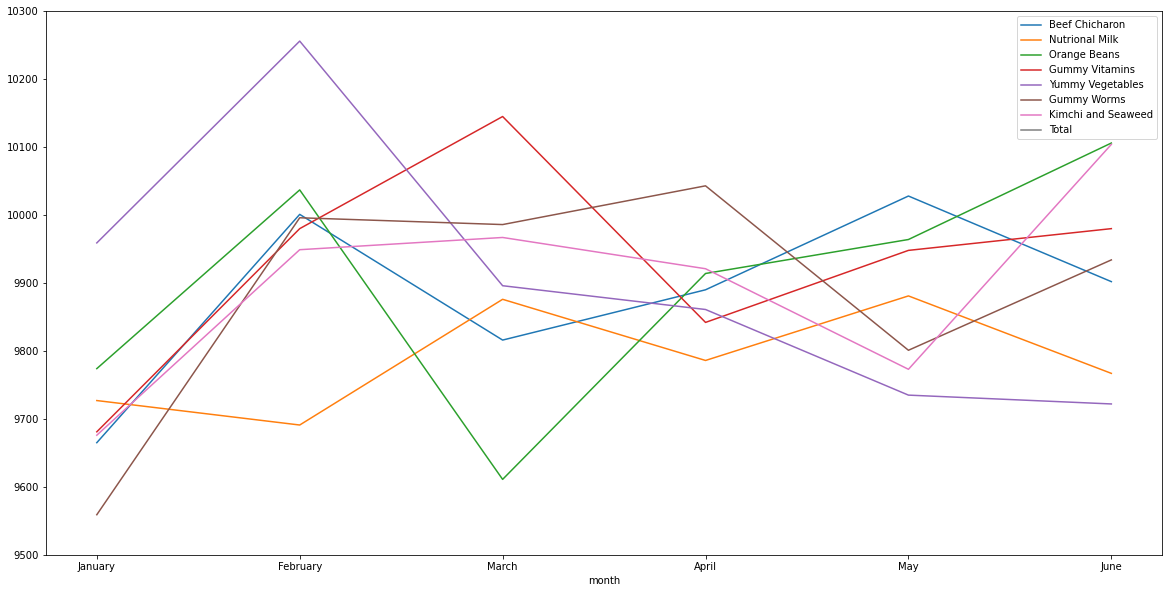

In [5]:
# line graph of sales per item over the 6 month period
# this shows the trend in sales per item from January to June, which reflects monthly demands per item
df_trend=df_pivot.drop('Total')
df_trend.plot(kind="line", figsize = (20, 10), ylim = [9500, 10300])

<AxesSubplot:>

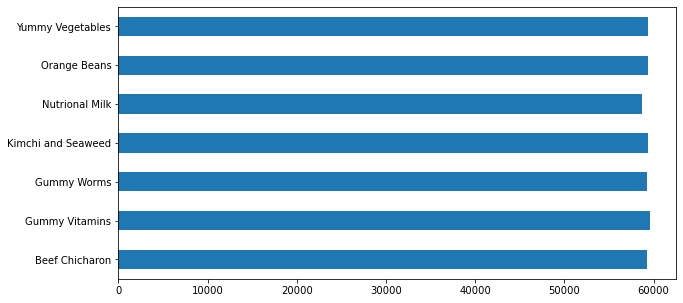

In [6]:
# bar graph of total sales per item
# this shows how each item performed relative to one another based on their total sales over the 6-month period
months = ['January', 'February', 'March', 'April', 'May', 'June']
df_tpivot = pd.pivot_table(data = df_td, index = 'month', values = ol, aggfunc = 'sum').reindex(months)
df_tpivot = df_tpivot.T.rename(columns = {0: 'Items'})
df_tpivot['Total'] = df_tpivot.apply(np.sum, axis = 1)
df_tpivot=df_tpivot['Total']
df_tpivot.plot.barh(rot=0,figsize=(10,5))

<AxesSubplot:ylabel='Total'>

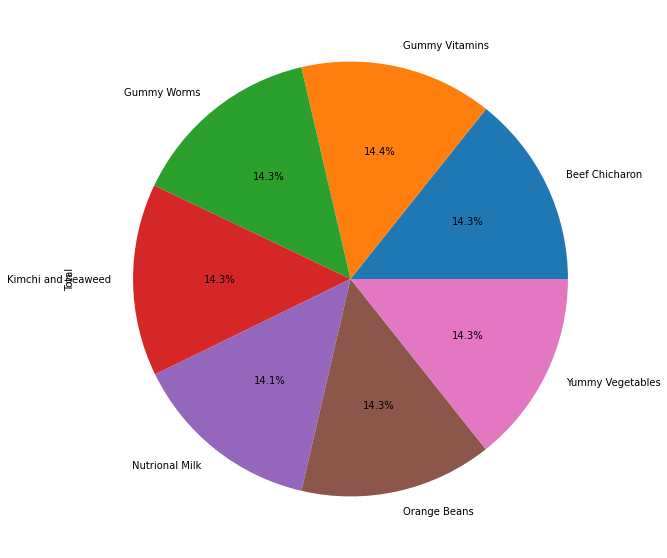

In [7]:
# pie chart of the breakdown of total sales by item
# this shows the proportion of item sales and is another way of evaluating relative item performance
df_tpivot.plot(kind='pie', figsize = (15, 10), autopct='%1.1f%%')

In [8]:
# pivot table with retail price per item
# this shows how much a piece of each item was sold to the customers
df_price

,retail price
Beef Chicharon,1299.0
Nutrional Milk,1990.0
Orange Beans,199.0
Gummy Vitamins,1500.0
Yummy Vegetables,500.0
Gummy Worms,150.0
Kimchi and Seaweed,799.0


In [9]:
# pivot table of generated revenue per item per month
# this shows how much the business earned in revenue for each item under each month, along with their corresponding total revenues
df_rev = df_pivot.drop('Total', axis = 1)
df_rev = df_rev.multiply(np.array(df_price.T), axis = 'columns')
df_rev['Total'] = df_rev.sum(axis = 1)
df_rev

,Beef Chicharon,Nutrional Milk,Orange Beans,Gummy Vitamins,Yummy Vegetables,Gummy Worms,Kimchi and Seaweed,Total
month,,,,,,,,
January,12554835.0,19356730.0,1945026.0,14521500.0,4979500.0,1433850.0,7731124.0,62522565.0
February,12991299.0,19285090.0,1997363.0,14970000.0,5128000.0,1499400.0,7949251.0,63820403.0
March,12750984.0,19653240.0,1912589.0,15217500.0,4948000.0,1497900.0,7963633.0,63943846.0
April,12847110.0,19474140.0,1972886.0,14763000.0,4930500.0,1506450.0,7926879.0,63420965.0
May,13026372.0,19663190.0,1982836.0,14922000.0,4867500.0,1470150.0,7808627.0,63740675.0
June,12862698.0,19436330.0,2011094.0,14970000.0,4861000.0,1490100.0,8073096.0,63704318.0
Total,77033298.0,116868720.0,11821794.0,89364000.0,29714500.0,8897850.0,47452610.0,381152772.0


<AxesSubplot:>

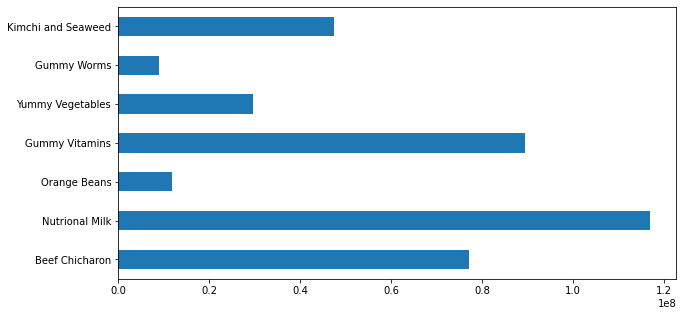

In [10]:
# bar graph of total generated revenue per item
# this compares the total revenue generated per item, where you can see which item contributed 
    # the most and the least in terms of the company's revenue over the 6 month period
df_trev = df_rev.T.rename(columns = {0: 'Items'})
df_trev = df_trev.drop('Total')
df_trev = df_trev['Total']
df_trev.plot.barh(rot=0,figsize=(10,5))

<AxesSubplot:ylabel='Total'>

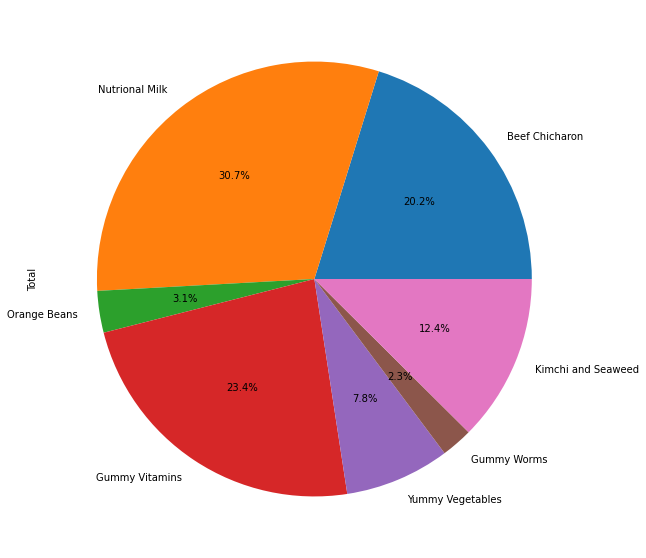

In [11]:
# pie chart of the breakdown of total generated revenue by item
# this shows the percentage contributed by each item towards the company's total revenue throughout the 6-month period
df_trev.plot(kind='pie', figsize = (15, 10), autopct='%1.1f%%')

In [12]:
# pivot table with order count per item per sex
# this shows the breakdown of item orders by customers of each sex
df_sex = pd.pivot_table(data = df_td, index = 'sex', values = ol, aggfunc = sum)
df_sex

,Beef Chicharon,Gummy Vitamins,Gummy Worms,Kimchi and Seaweed,Nutrional Milk,Orange Beans,Yummy Vegetables
sex,,,,,,,
F,29438,29292,29486,29587,29001,29650,29528
M,29864,30284,29833,29803,29727,29756,29901


<AxesSubplot:xlabel='sex'>

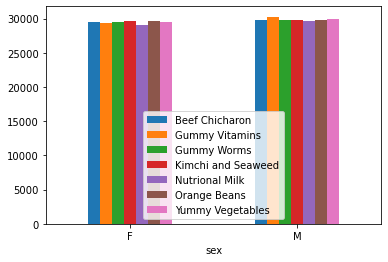

In [13]:
# bar graph of male vs female sales per item
# this shows the item distribution for customers based on sex
df_sex.plot.bar(rot=0)

array([<AxesSubplot:ylabel='F'>], dtype=object)

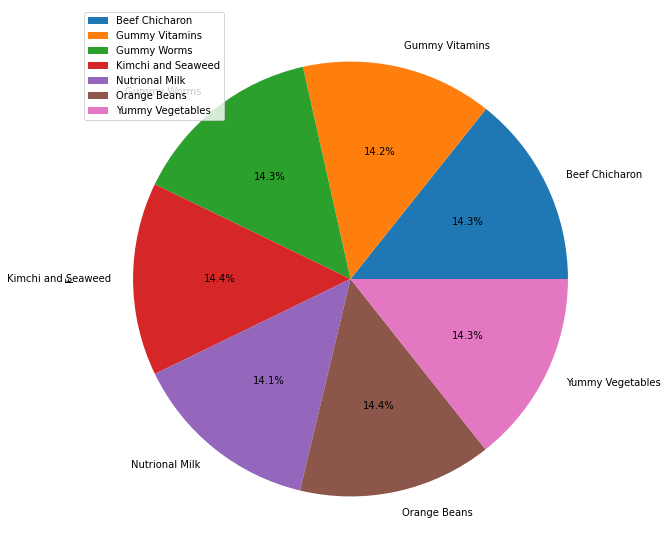

In [14]:
# pie chart of total item sales for female
# this shows the item proportions for female customers
df_F = df_sex.drop('M')
df_F = df_F.T.rename(columns = {0: 'Items'})
df_F.plot(kind='pie', figsize = (15, 10), subplots=True, autopct='%1.1f%%')

array([<AxesSubplot:ylabel='M'>], dtype=object)

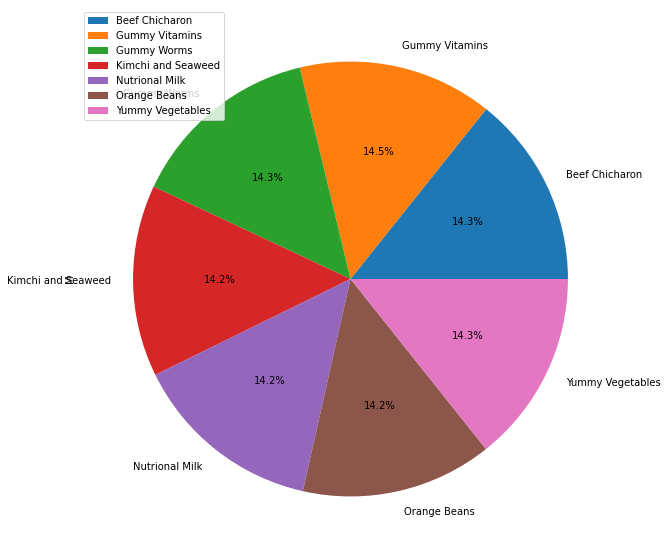

In [15]:
# pie chart of total item sales for male
# this shows the item proportions for male customers
df_M = df_sex.drop('F')
df_M = df_M.T.rename(columns = {0: 'Items'})
df_M.plot(kind='pie', figsize = (15, 10), subplots=True, autopct='%1.1f%%')

In [16]:
# pivot table ranking total sales based on customers' generation
# this shows the sizes of the generational market segments based on total sales, along with item breakdowns
df_gen = pd.pivot_table(data = df_td, index = ('generation'), values = ol, aggfunc = sum, margins = True, margins_name = 'Total').reindex(['Greatest Gen', 'Silent Gen', 'Baby Boomer', 'Gen X', 'Millenials', 'Gen Z', 'Gen Alpha'])
df_gen['Total'] = df_gen.sum(axis = 1)
df_gen.sort_values(by = 'Total', ascending = False)

,Beef Chicharon,Gummy Vitamins,Gummy Worms,Kimchi and Seaweed,Nutrional Milk,Orange Beans,Yummy Vegetables,Total
generation,,,,,,,,
Silent Gen,10793,10863,10878,10953,10784,10942,10985,76198
Greatest Gen,9910,9924,9927,9610,9960,9725,9940,68996
Baby Boomer,9751,9513,9460,9353,9305,9287,9332,66001
Gen Z,8285,8271,8314,8386,8254,8499,8285,58294
Gen X,8056,8325,8076,8059,7943,8150,7980,56589
Millenials,7722,7844,7815,8140,7627,7743,8052,54943
Gen Alpha,4785,4836,4849,4889,4855,5060,4855,34129


<AxesSubplot:ylabel='generation'>

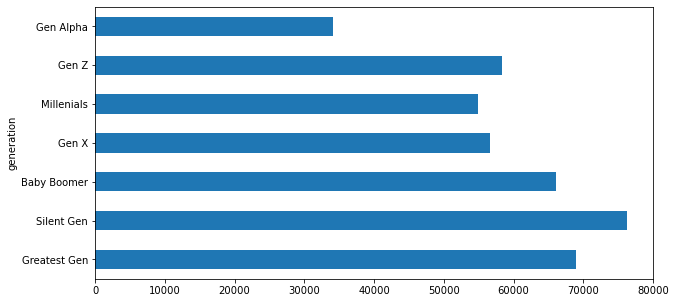

In [17]:
# bar graph of total sales per generation
# this compares the sizes of the generational market segments and shows how many sales each contributed
df_tgen = df_gen['Total']
df_tgen.plot.barh(rot=0, figsize=(10,5))

array([<AxesSubplot:ylabel='Total'>], dtype=object)

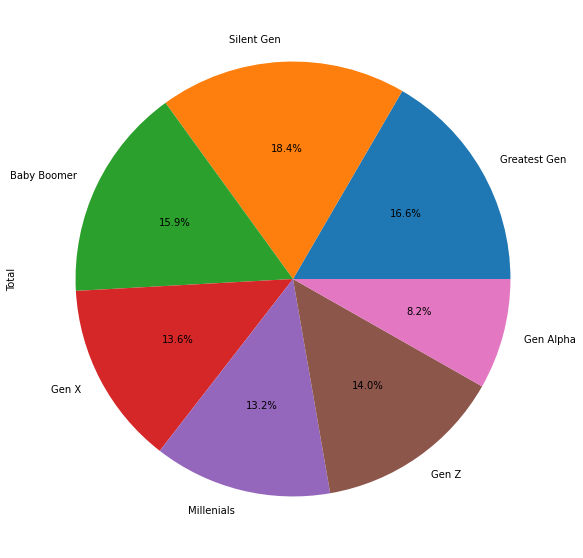

In [18]:
# pie chart of total sales per generation
# this shows the sales proportions of the generational market segments
    # how much percent of the whole market is under each generation
    # shows which generation their marketing efforts should focus on
df_tgen.plot(kind='pie', figsize = (15, 10), subplots=True, autopct='%1.1f%%')

In [19]:
# pivot table ranking total sales based on customer demographic (generation and sex)
# this shows the size of each market segment (demographic)
df_gensex = pd.pivot_table(data = df_td, index = ['sex','generation'], values = ol, aggfunc = np.sum)
df_gensex['Total'] = df_gensex.sum(axis = 1)
df_gensex.sort_values(by = 'Total', ascending = False)

Beef Chicharon  Gummy Vitamins  Gummy Worms  \
sex generation                                                  
M   Silent Gen              5819            5793         5795   
F   Silent Gen              4974            5070         5083   
M   Greatest Gen            4944            5147         5086   
F   Baby Boomer             5136            4967         5127   
    Greatest Gen            4966            4777         4841   
M   Baby Boomer             4615            4546         4333   
F   Gen Z                   4179            4098         4151   
M   Gen Z                   4106            4173         4163   
F   Gen X                   4024            4075         4103   
M   Millenials              3950            3944         4077   
    Gen X                   4032            4250         3973   
F   Millenials              3772            3900         3738   
    Gen Alpha               2387            2405         2443   
M   Gen Alpha               2398            2431         2406   

                  Kimchi and Seaweed  Nutrional Milk  Orange Beans  \
sex generation                                                       
M   Silent Gen                  5826            5740          5762   
F   Silent Gen                  5127            5044          5180   
M   Greatest Gen                4778            5097          4946   
F   Baby Boomer                 4834            4874          4910   
    Greatest Gen                4832            4863          4779   
M   Baby Boomer                 4519            4431          4377   
F   Gen Z                       4223            4109          4183   
M   Gen Z                       4163            4145          4316   
F   Gen X                       4063            3995          4167   
M   Millenials                  4201            3871          3956   
    Gen X                       3996            3948          3983   
F   Millenials                  3939            3756          3787   
    Gen Alpha                   2569            2360          2644   
M   Gen Alpha                   2320            2495          2416   

                  Yummy Vegetables  Total  
sex generation                             
M   Silent Gen                5850  40585  
F   Silent Gen                5135  35613  
M   Greatest Gen              5014  35012  
F   Baby Boomer               4922  34770  
    Greatest Gen              4926  33984  
M   Baby Boomer               4410  31231  
F   Gen Z                     4206  29149  
M   Gen Z                     4079  29145  
F   Gen X                     4112  28539  
M   Millenials                4253  28252  
    Gen X                     3868  28050  
F   Millenials                3799  26691  
    Gen Alpha                 2428  17236  
M   Gen Alpha                 2427  16893

array([<AxesSubplot:ylabel='Total'>], dtype=object)

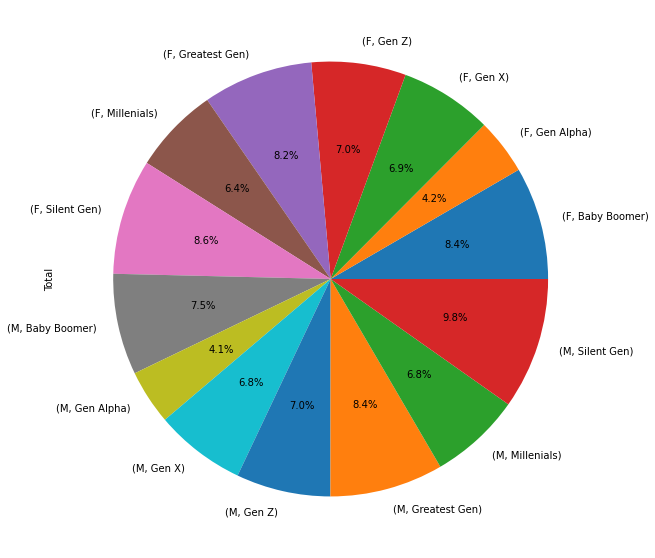

In [20]:
# pie chart of demographic (generation and sex) for total sales
# this shows the proportions of their market segments
    # how much percent of the whole market is under each demographic
    # shows which demographic their marketing efforts should focus on

df_tgensex = df_gensex['Total']
df_tgensex.plot(kind='pie', figsize = (15, 10), subplots=True, autopct='%1.1f%%')

In [21]:
# pivot table of total sales per state
df_state = pd.pivot_table(data = df_td, index = 'state', values = ol, aggfunc = sum)
df_state['Total'] = df_state.apply(np.sum, axis = 1)
df_state

,Beef Chicharon,Gummy Vitamins,Gummy Worms,Kimchi and Seaweed,Nutrional Milk,Orange Beans,Yummy Vegetables,Total
state,,,,,,,,
Alabama,1008,1110,1164,1078,1155,1061,1033,7609
Alaska,962,1074,992,1057,1011,1056,997,7149
Arizona,1156,1043,1096,1055,1157,1121,1029,7657
Arkansas,1011,1058,1012,977,956,919,943,6876
Armed Forces Europe,2023,2139,2020,2110,2178,2208,2110,14788
Armed Forces Pacific,1913,2077,2060,2076,1910,2040,1985,14061
Armed Forces the Americas,2068,2226,2351,2033,1955,2164,2224,15021
California,1005,993,882,892,1025,948,897,6642
Colorado,1124,980,951,1077,996,991,981,7100


In [22]:
# pivot table of top 5 states with most transactions
# this shows the top 5 states that had the most transactions over the 6-month period
# number of states shown can easily be changed by replacing the number enclosed in paranthesis after "head"
df_state.sort_values(by = ['Total'], ascending = False).head(5)

,Beef Chicharon,Gummy Vitamins,Gummy Worms,Kimchi and Seaweed,Nutrional Milk,Orange Beans,Yummy Vegetables,Total
state,,,,,,,,
Armed Forces the Americas,2068,2226,2351,2033,1955,2164,2224,15021
Armed Forces Europe,2023,2139,2020,2110,2178,2208,2110,14788
Armed Forces Pacific,1913,2077,2060,2076,1910,2040,1985,14061
Wyoming,1247,1304,1257,1330,1401,1367,1328,9234
Hawaii,1275,1192,1263,1291,1288,1255,1152,8716


<AxesSubplot:ylabel='state'>

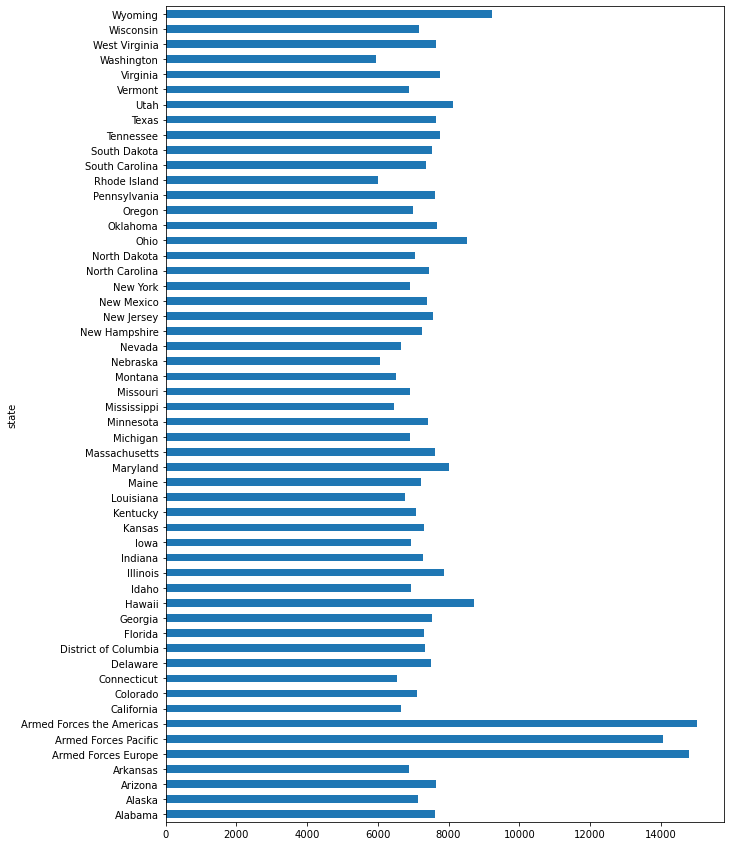

In [23]:
# bar graph of total sales per state
# this shows the relative performance of each state based on total sales throughout the 6-month period
df_tstate = df_state['Total']
df_tstate.plot.barh(rot=0, figsize=(10,15))

array([<AxesSubplot:ylabel='Total'>], dtype=object)

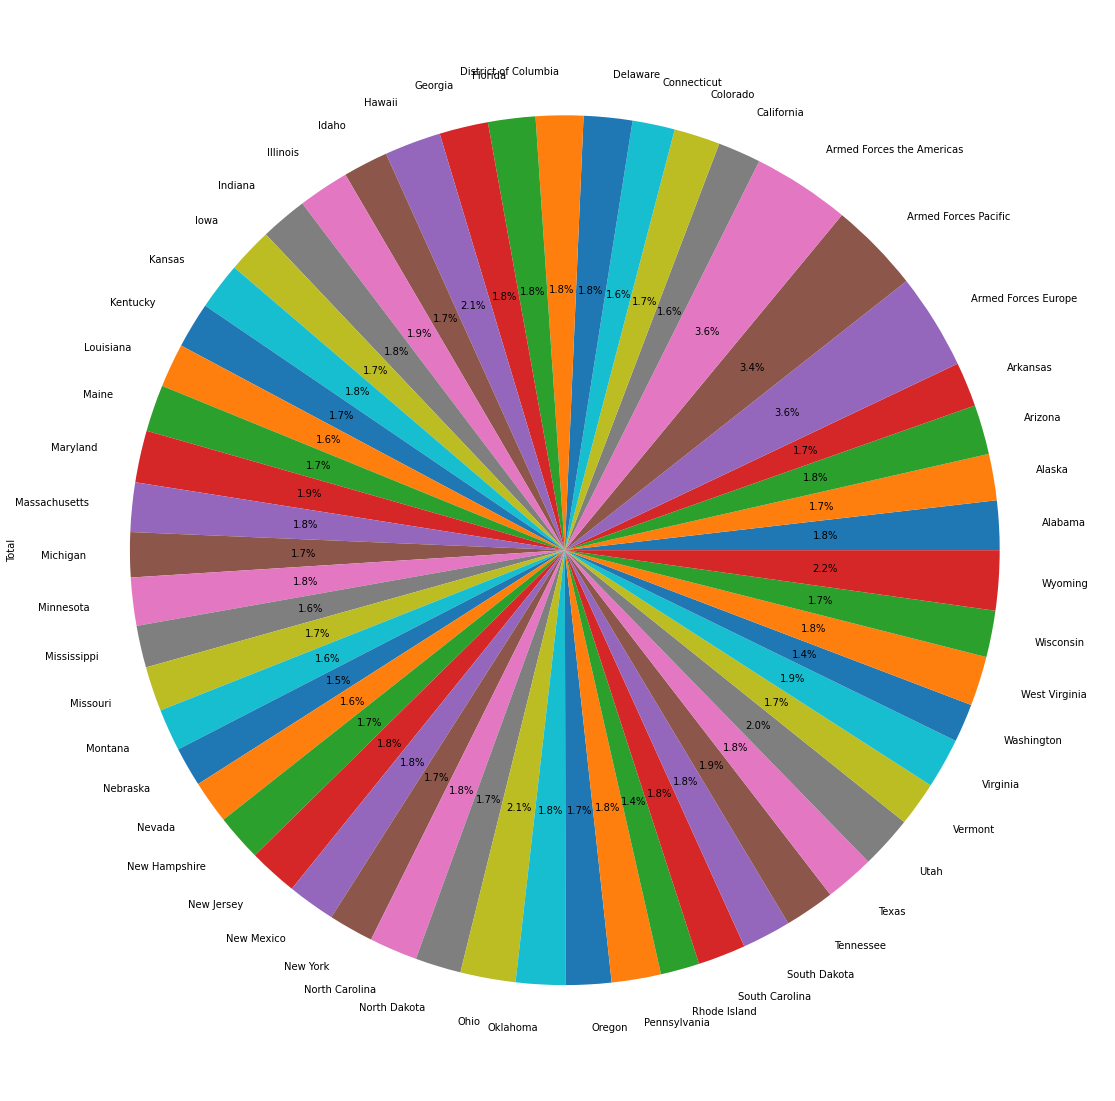

In [24]:
# pie chart of each state for total sales
# this shows the proportions of each state
    # how much percent of the whole market is under each state
    # shows which state their marketing efforts should focus on

df_tstate.plot(kind='pie',figsize = (20, 20), subplots=True, autopct='%1.1f%%')

In [25]:
# list of top 5 customers throughout the 6-month period
# this shows the customers that ordered from their company the most
df_user = pd.pivot_table(data = df_tdval, index = 'username', columns = 'month', values = 'item_num', aggfunc = len, fill_value = 0)[months]
df_users = pd.DataFrame(df_user.sum(axis = 1), columns = ['number of transactions'])

# number of customers shown can be easily adjusted by replacing the number enclosed in paranthesis after "head"
df_users.sort_values(by = 'number of transactions', ascending = False).head(5)

,number of transactions
username,
tsmith,53
cjones,52
zmartin,48
ysmith,46
esmith,44


In [26]:
# function that will categorize the customer based on loyalty categories (engaged, repeater, inactive, first-timer)
def check(loyalty):
    out = ""
    loyalty = loyalty.lstrip('0')
    if loyalty == "":
        return "none" 
    if loyalty[-1] == '0':
        out = out + "inactive"
    if len(loyalty) == 1:
        out = out + "first timer"        
    try: 
        if loyalty[-2] + loyalty [-1] == '11':
            out = out + "repeater"
    except:
        pass
    if set(loyalty) == {'1'}:
        out = out + "engaged"   
    if out == "":
        return "none"
    else:
        return out
        
def sconvert(i):
    return "".join([str(x) for x in list(i)])

# apply the function to categorize each customer
loyalties = ['engaged', 'repeater', 'inactive', 'first timer']
df_loyalty = []

for x in months:
    df_user[x] = df_user[x].apply(lambda x: 0 if x == 0 else 1)

for x in months:
    df_user['loyalty'] = df_user.loc[:,'January': x].apply(sconvert, axis = 1)
    df_user[x + ' loyalty'] = df_user['loyalty'].apply(check)

for x in months:
    df_loyal = dict()
    for y in loyalties:
        df_loyal[y] = len(df_user[df_user[x + ' loyalty'].str.contains(y)])
    df_loyalty.append(df_loyal)

# pivot table showing the number of engaged, repeater, and inactive customers per month
df_lp = pd.DataFrame(df_loyalty, index = months)
df_lp

,engaged,repeater,inactive,first timer
January,6583,0,0,6583
February,6630,5167,1416,1463
March,5579,5239,1728,340
April,4468,5191,1912,94
May,3590,5126,1915,22
June,2911,5208,1840,3


<AxesSubplot:>

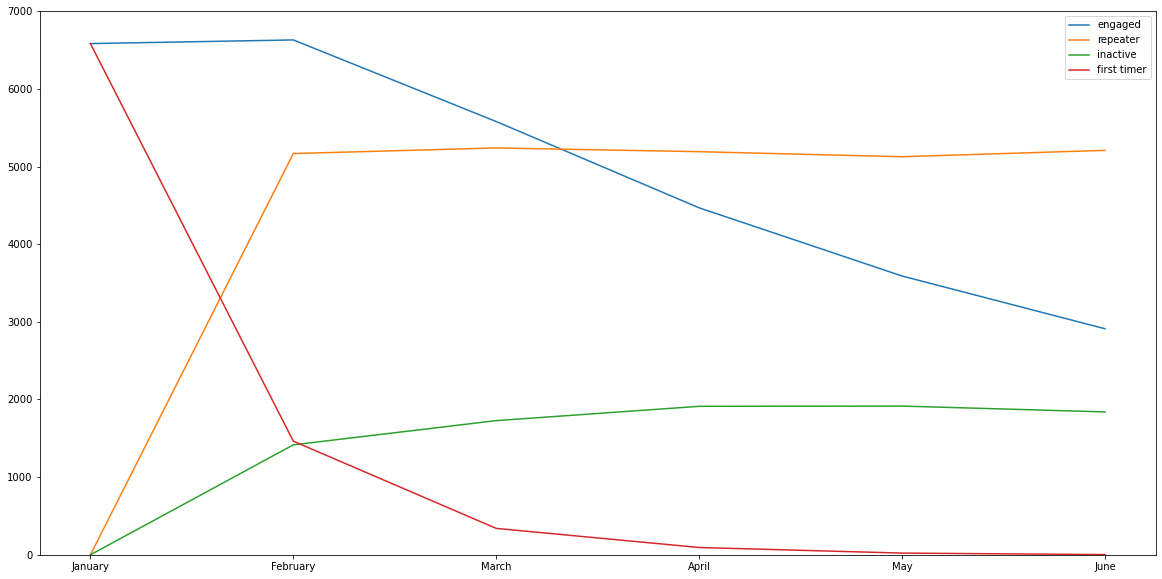

In [27]:
# line graph of the number of customers per loyalty category throughout the 6-month period
# this shows the trend of customer loyalty from January to June
df_lp.plot(kind="line", figsize = (20, 10), ylim = [0, 7000])

In [28]:
f.close()